In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from fitter import Fitter


%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = [8, 6]

/home/sergey/code/statistics/env/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Чтение json файла.

In [2]:
df = pd.read_json('./deviation.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 0 to 1346
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1347 non-null   object 
 1   gt_corners    1347 non-null   int64  
 2   rb_corners    1347 non-null   int64  
 3   mean          1347 non-null   float64
 4   max           1347 non-null   float64
 5   min           1347 non-null   float64
 6   floor_mean    1347 non-null   float64
 7   floor_max     1347 non-null   float64
 8   floor_min     1347 non-null   float64
 9   ceiling_mean  1347 non-null   float64
 10  ceiling_max   1347 non-null   float64
 11  ceiling_min   1347 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 136.8+ KB


In [3]:
df.describe()

,gt_corners,rb_corners,mean,max,min,floor_mean,floor_max,floor_min,ceiling_mean,ceiling_max,ceiling_min
count,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000
mean,4.307350,4.307350,12.895320,25.448011,2.920388,11.022443,20.405499,3.146246,14.768198,24.848020,5.521437
std,0.814412,0.814412,21.839948,42.758159,9.258972,19.136320,33.189081,9.559611,26.047057,42.345579,14.460565
min,4.000000,4.000000,0.192973,0.323886,0.007456,0.134686,0.178059,0.007456,0.123169,0.220846,0.009268
25%,4.000000,4.000000,0.658488,1.243804,0.147432,0.514150,0.888043,0.164668,0.742915,1.180960,0.306071
50%,4.000000,4.000000,2.123456,4.703514,0.279876,1.932503,4.008014,0.304374,2.159995,3.777277,0.600597
75%,4.000000,4.000000,14.810982,28.312051,0.674444,13.430288,24.986504,0.801416,15.150233,27.551533,1.840563
max,10.000000,10.000000,121.301055,179.165483,81.764483,121.244083,177.961811,81.791505,157.387474,179.165483,144.472533


In [4]:
df.head()

,name,gt_corners,rb_corners,mean,max,min,floor_mean,floor_max,floor_min,ceiling_mean,ceiling_max,ceiling_min
0,Schlafzimmer,4,4,3.956313,8.562939,0.274574,3.987864,8.562939,0.274574,3.924762,8.501885,0.331494
1,Küche,4,4,23.019122,52.605437,0.724299,1.253103,1.897612,0.724299,44.785141,52.605437,36.880814
2,Bathroom,4,4,1.013833,1.950322,0.301673,0.659138,1.318714,0.301673,1.368528,1.950322,0.878106
3,Lounge/Diner,8,8,3.832620,18.236935,0.173307,3.600083,15.041431,0.173307,4.065157,18.236935,0.253457
4,Essbereich,4,4,8.017758,15.642853,0.762948,7.819446,15.399635,0.762948,8.216069,15.642853,0.909029


## Проверка корреляции между данными

[Text(0.5, 1.0, 'Heatmap of correlations')]

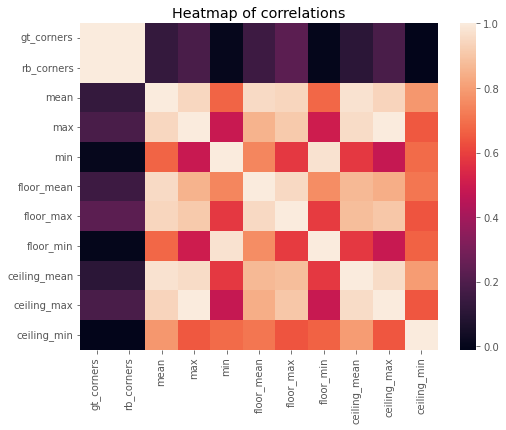

In [5]:
heatmap = sns.heatmap(df.corr())
heatmap.set(title="Heatmap of correlations")

## Оценка выбросов без фильтрации с помощью ящика с усами для среднего, максимального и минимального отклонения

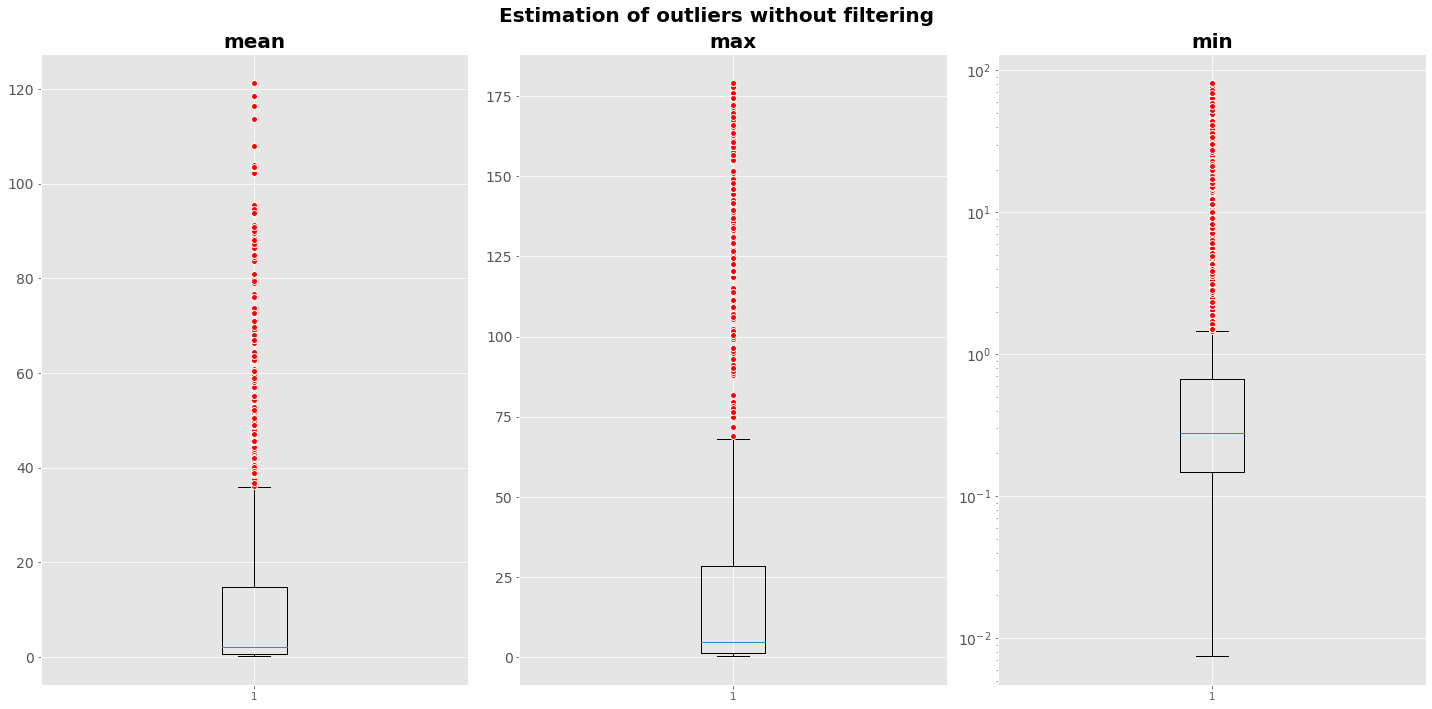

In [6]:
dff = df[["mean","max","min"]]
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig, axs = plt.subplots(1, len(dff.columns), figsize=(20,10))
for i, ax in enumerate(axs.flat):
    ax.boxplot(dff.iloc[:,i], flierprops=red_circle)
    ax.set_title(dff.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    if dff.columns[i] == 'min':
        ax.semilogy()
plt.suptitle("Estimation of outliers without filtering", fontsize=20, fontweight='bold')
plt.tight_layout()

## Фильтрация данных по границам усов ящика

In [7]:
filter_df = df
for colomn in list(df)[3:]:
    Q1 = filter_df[colomn].quantile(0.25)
    Q3 = filter_df[colomn].quantile(0.75)
    IQR = Q3 - Q1
    filter_df = filter_df[(filter_df[colomn] > (Q1-1.5*IQR)) & (filter_df[colomn] < (Q3+1.5*IQR))]


## Сравнение количесва записей до и после фильтрации

[Text(0, 0, '1347'), Text(0, 0, '581')]

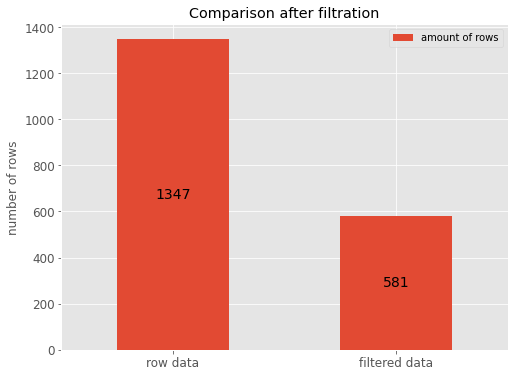

In [8]:
compare_df = pd.DataFrame({"amount of rows": (df.shape[0], filter_df.shape[0])}, index=('row data', 'filtered data'))
ax = compare_df.plot(kind='bar', title='Comparison after filtration', ylabel='number of rows')
plt.xticks(rotation=0, horizontalalignment="center", fontsize=12)
plt.yticks(fontsize=12)
ax.bar_label(ax.containers[0], label_type='center', fontsize=14)


## Оценка выбросов после фильтрации с помощью ящика с усами для среднего, максимального и минимального отклонения

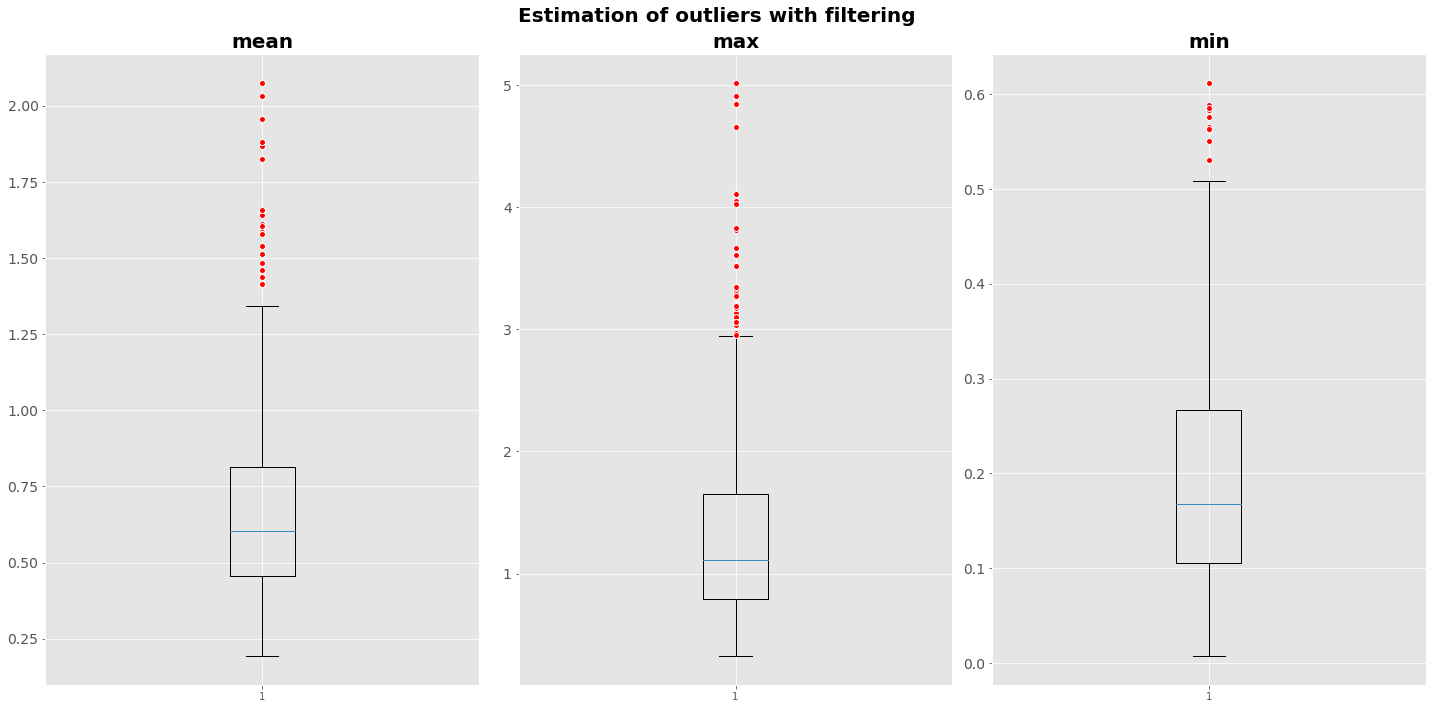

In [9]:

dff = filter_df[["mean","max","min"]]
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig, axs = plt.subplots(1, len(dff.columns), figsize=(20,10))
for i, ax in enumerate(axs.flat):
    ax.boxplot(dff.iloc[:,i], flierprops=red_circle)
    ax.set_title(dff.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
plt.suptitle("Estimation of outliers with filtering", fontsize=20, fontweight='bold')
plt.tight_layout()

## Гистограмма среднего отклонения угла по всему сету

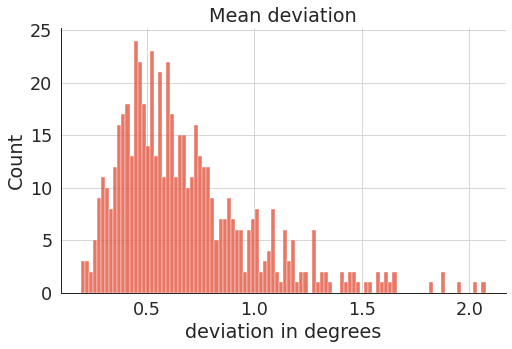

In [10]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
mean_hist = sns.displot(data=filter_df, x="mean", kind="hist", bins = 100, aspect = 1.5)
mean_hist.set(title='Mean deviation', xlabel='deviation in degrees')
plt.grid()

## Подбор подходящего распределения для среднего отклонения по всему сету

Text(0.5, 1.0, 'Suitable distributions')

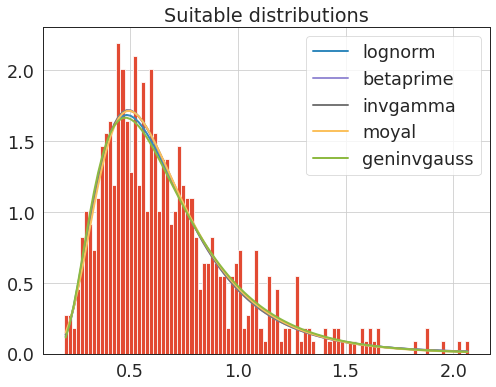

In [11]:
mean = filter_df["mean"].values
f = Fitter(mean, distributions=['lognorm', 'betaprime', 'invgamma', 'moyal', 'geninvgauss'])
f.fit()
f.summary()
plt.title("Suitable distributions")

## Гистограммы среднего отклонения угла по полу и потолку

<Figure size 576x432 with 0 Axes>

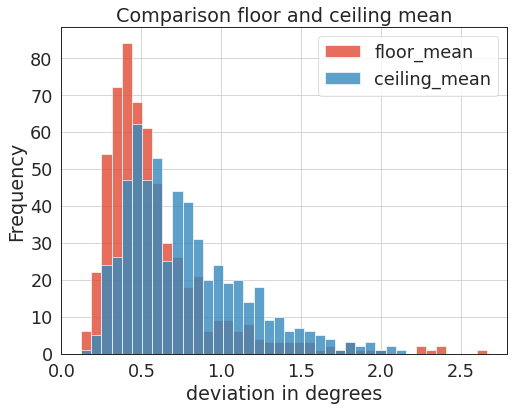

In [12]:
plt.figure()
filter_df[["floor_mean", "ceiling_mean"]].plot(kind='hist', title='Comparison floor and ceiling mean', alpha=0.8, bins=40)
plt.xlabel('deviation in degrees')
plt.grid()

## Сравнение стандартных отклонений для всего сета, пола и потолка

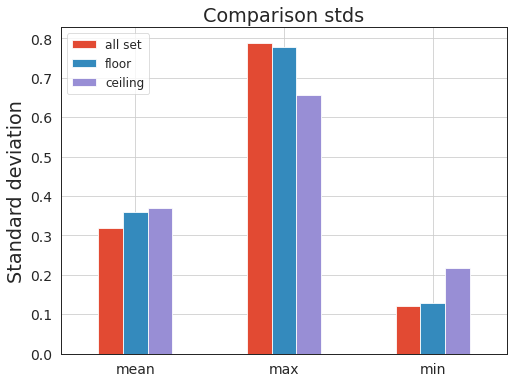

In [13]:
std_df = pd.DataFrame({
    "all set": filter_df[["mean", "max", "min"]].std().values.tolist(),
    "floor": filter_df[["floor_mean", "floor_max", "floor_min"]].std().values.tolist(),
    "ceiling": filter_df[["ceiling_mean", "ceiling_max", "ceiling_min"]].std().values.tolist()
},
index = ['mean', 'max', 'min'])
std_df.plot(kind='bar', title='Comparison stds', ylabel='Standard deviation')
plt.xticks(rotation=0, horizontalalignment="center", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=2, prop={'size': 12})
plt.grid()

## Ранжирование средних отклонений для всего сета, пола и потолка

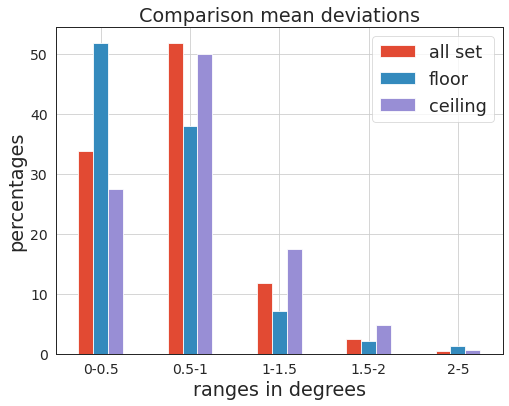

In [14]:
deviation_df = pd.DataFrame({},
index = ['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-5'])
df_mean_ranges = filter_df

for m,label in zip(("mean", "floor_mean", "ceiling_mean"),("all set", "floor", "ceiling")):
    df_mean_ranges["ranges"] = pd.cut(df_mean_ranges[m], [0,0.5,1,1.5,2,5])
    df_ranges = df_mean_ranges[[m, "ranges"]].groupby(by="ranges").count()
    df_ranges['percentages'] = (df_ranges[m] / df_ranges[m].sum()) * 100
    deviation_df[label] = df_ranges['percentages'].values.tolist()
deviation_df.plot(kind='bar',title='Comparison mean deviations', xlabel='ranges in degrees', ylabel='percentages')
plt.xticks(rotation=0, horizontalalignment="center", fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
